In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

In [4]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df = pd.read_csv('/content/DMC Historical Data_Cleaned.csv', usecols=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()
df = df.asfreq('B')

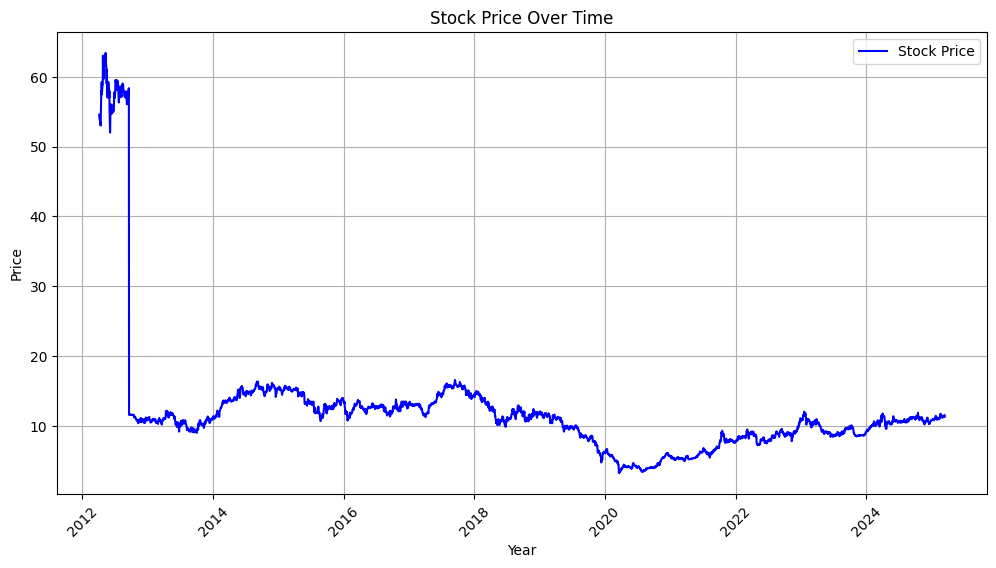

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label="Stock Price", color='blue')
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Stock Price Over Time")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.grid()
plt.show()

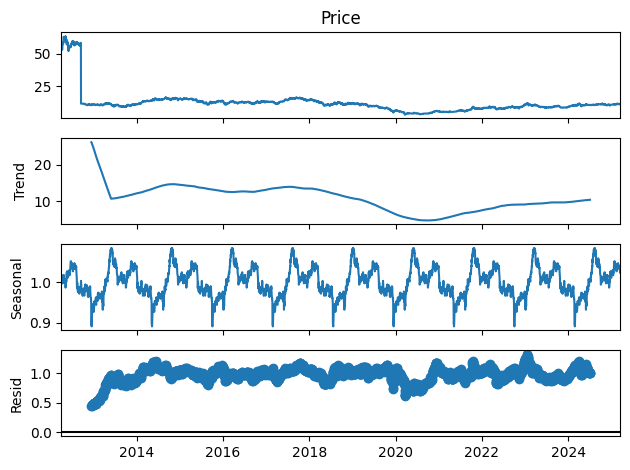

In [6]:
results = seasonal_decompose(df['Price'], model='multiplicative', period=365)
results.plot()
plt.show()

In [7]:
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
train = df.iloc[:train_size]
val = df.iloc[train_size:train_size+val_size]
test = df.iloc[train_size+val_size:]

In [8]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

In [9]:
scaled_train = np.array(scaled_train).reshape(-1, 1)
scaled_val = np.array(scaled_val).reshape(-1, 1)
scaled_test = np.array(scaled_test).reshape(-1, 1)

In [10]:
n_input = 90
n_features = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
val_generator = TimeseriesGenerator(scaled_val, scaled_val, length=n_input, batch_size=1)

In [11]:
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_input, n_features)),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 90, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
checkpoint = ModelCheckpoint("DMC_model.h5", save_best_only=True, monitor='val_loss', mode='min')

In [13]:
history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[early_stopping, checkpoint])

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2612/2612 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0025

2612/2612 ━━━━━━━━━━━━━━━━━━━━ 252s 95ms/step - loss: 0.0025 - val_loss: 1.3483e-04
Epoch 2/30
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0022

2612/2612 ━━━━━━━━━━━━━━━━━━━━ 251s 96ms/step - loss: 0.0022 - val_loss: 1.2027e-04
Epoch 3/30
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 8.8127e-04

2612/2612 ━━━━━━━━━━━━━━━━━━━━ 247s 95ms/step - loss: 8.8148e-04 - val_loss: 3.8058e-05
Epoch 4/30
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 245s 94ms/step - loss: 0.0012 - val_loss: 6.2389e-05
Epoch 5/30
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 250s 96ms/step - loss: 8.7004e-04 - val_loss: 4.7929e-05
Epoch 6/30
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0014

2612/2612 ━━━━━━━━━━━━━━━━━━━━ 244s 93ms/step - loss: 0.0014 - val_loss: 2.7692e-05
Epoch 7/30
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 248s 95ms/step - loss: 0.0014 - val_loss: 4.7787e-05
Epoch 8/30
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 243s 93ms/step - loss: 0.0016 - val_loss: 1.0867e-04
Epoch 9/30
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 9.9463e-04

2612/2612 ━━━━━━━━━━━━━━━━━━━━ 242s 93ms/step - loss: 9.9462e-04 - val_loss: 2.4090e-05
Epoch 10/30
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 6.5472e-04

2612/2612 ━━━━━━━━━━━━━━━━━━━━ 244s 93ms/step - loss: 6.5478e-04 - val_loss: 1.5563e-05
Epoch 11/30
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 246s 94ms/step - loss: 6.7404e-04 - val_loss: 2.9294e-05
Epoch 12/30
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 242s 93ms/step - loss: 4.2658e-04 - val_loss: 1.1373e-04
Epoch 13/30
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 264s 93ms/step - loss: 0.0013 - val_loss: 2.0027e-05
Epoch 14/30
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 243s 93ms/step - loss: 5.8218e-04 - val_loss: 3.9671e-05
Epoch 15/30
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 241s 92ms/step - loss: 8.8053e-04 - val_loss: 4.0520e-05


In [14]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model.save("DMC_Model.h5")

In [15]:
full_scaled = scaler.transform(df)
full_scaled = np.array(full_scaled).reshape(-1, 1)
first_eval_batch = full_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

future_steps = 7
future_predictions = []

for i in range(future_steps):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [16]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [17]:
actual_recent = df.tail(23)

In [18]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=future_steps, freq='B')

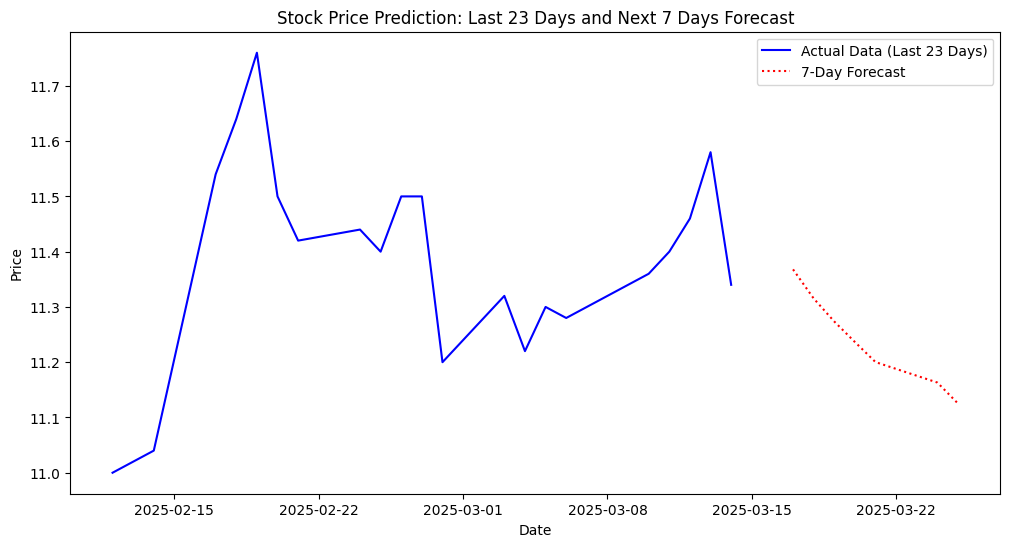

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(actual_recent.index, actual_recent['Price'], label='Actual Data (Last 23 Days)', color='blue')
plt.plot(future_dates, future_predictions, linestyle='dotted', color='red', label='7-Day Forecast')
plt.legend()
plt.title("Stock Price Prediction: Last 23 Days and Next 7 Days Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [20]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions.flatten()
})

In [21]:
forecast_df.to_csv('DMC_predictions.csv', index=False)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print("Future predictions saved to 'future_predictions.csv'.")

Future predictions saved to 'future_predictions.csv'.
